# TF-IDF


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# evaluacion
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils.multiclass import unique_labels

#  gráficas y realizar análisis exploratorio de los datos
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from tqdm import tqdm

## Carga de datos

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
df_train_set = pd.read_csv('/content/drive/MyDrive/TFM/notebooks/entrega/train_limpio.csv', index_col = 0)
df_train_set

,author,author_name,candidate,candidate_name,label
3892,"Weingarten , JA Oxidized HDL , Adipokines , En...","Weingarten, JA","Estevez-Fraga , C Biological clinical characte...","Estevez-Fraga, C",0
64711,Cristopher I. Lang One Class Process Anomaly D...,Cristopher I. Lang,"Johnson , Eileanoir B . Multi-Study Model-Base...","Johnson, Eileanoir B.",0
22531,S. Guo UIR-Net : Object Detection Infrared Ima...,S. Guo,"Guo , Process Monitoring Fault Prediction Mult...","Guo, S",1
28419,"Thompson , Ellen Detecting early onset anthrac...","Thompson, Ellen","E. Thompson Oxidized HDL , Adipokines , Endoth...",E. Thompson,1
41685,H. Zetterberg Mutant huntingtin neurofilament ...,H. Zetterberg,"Zetterberg , H Brain-derived neurotrophic fact...","Zetterberg, H",1
...,...,...,...,...,...
11097,"Caron , NS Mutant Huntingtin Cleared Brain via...","Caron, NS","Caron , Nicholas Cerebrospinal fluid biomarker...","Caron, Nicholas S",1
19579,"Langley , C Biological clinical characteristic...","Langley, C","Sodhi , K Biomarker panel early screening tras...","Sodhi, K",0
24980,E. Wilson Intelligent Optimization Dosing Unif...,E. Wilson,W. Guo Process Monitoring Fault Prediction Mul...,W. Guo,0
70520,"Parker , C Biological clinical characteristics...","Parker, C",Z. Ye Deep Negative Correlation Multisource Do...,Z. Ye,0


In [ ]:
df_val_set = pd.read_csv('/content/drive/MyDrive/TFM/notebooks/entrega/test_limpio.csv', index_col = 0)
df_val_set

,author,author_name,candidate,candidate_name,label
6676,"Wild , Edward J Mutant huntingtin neurofilamen...","Wild, Edward J","Wild , E J Longitudinal evaluation proton magn...","Wild, E J",1
8383,"Byrne , LM Longitudinal evaluation proton magn...","Byrne, LM","Guo , W Deep-Learning-Based Surrogate Model Th...","Guo, W",0
12080,"Gordon , B Cerebrospinal fluid mutant huntingt...","Gordon, B","Wu , H Diagnostic value alpha-fetoprotein , Le...","Wu, H",0
11992,"Banos , Raul Mutant Huntingtin Cleared Brain v...","Banos, Raul","Shapiro , JI Oxidized HDL , Adipokines , Endot...","Shapiro, JI",0
241,"Z. Chen DNN Deployment , Task Offloading , Res...",Z. Chen,H. Chaoui Developing Online Data-Driven State ...,H. Chaoui,0
...,...,...,...,...,...
2680,J. Cui Partial Transfer Learning Multidiscrimi...,J. Cui,"Harrington , M. G. Accumulation Cerebrospinal ...","Harrington, M. G.",0
3257,R. Jin Bi-LSTM-Based Two-Stream Network Machin...,R. Jin,"Lowe , AJ Longitudinal evaluation proton magne...","Lowe, AJ",0
5955,"Wild , EJ Biological clinical characteristics ...","Wild, EJ","Wild , Edward J Mutant huntingtin neurofilamen...","Wild, Edward J",1
8315,"Zetterberg , Henrik Longitudinal evaluation pr...","Zetterberg, Henrik","Parker , C Biological clinical characteristics...","Parker, C",0


In [ ]:
# función auxiliar que evalúa los resultados de una clasificación
def evaluate_model(y_true, y_pred, y_score=None, pos_label=1):
  print('==== Sumario de la clasificación ==== ')
  print(classification_report(y_true, y_pred))

  print('Accuracy -> {:.2%}\n'.format(accuracy_score(y_true, y_pred)))

  # graficar matriz de confusión
  display_labels = sorted(unique_labels(y_true, y_pred), reverse=True)
  cm = confusion_matrix(y_true, y_pred, labels=display_labels)

  z = cm[::-1]
  x = display_labels
  y =  x[::-1].copy()
  z_text = [[str(y) for y in x] for x in z]

  fig_cm = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

  fig_cm.update_layout(
      height=400, width=400,
      showlegend=True,
      margin={'t':150, 'l':0},
      title={'text' : 'Matriz de Confusión', 'x':0.5, 'y':0.95, 'xanchor': 'center'},
      xaxis = {'title_text':'Valor Real', 'tickangle':45, 'side':'top'},
      yaxis = {'title_text':'Valor Predicho', 'tickmode':'linear'},
  )
  fig_cm.show()


  # curva roc (definido para clasificación binaria)
  fig_roc = None
  if y_score is not None:
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    fig_roc = px.area(
        x=fpr, y=tpr,
        title = f'Curva ROC (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='Ratio Falsos Positivos', y='Ratio Verdaderos Positivos'),
        width=400, height=400
    )
    fig_roc.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

    fig_roc.update_yaxes(scaleanchor="x", scaleratio=1)
    fig_roc.update_xaxes(constrain='domain')

    fig_roc.show()

## Vectorización con TF-IDF

Se van a vectorizar los strings de características utilizando TF-IDF, para luego calcular la similitud de coseno entre ellos.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = TfidfVectorizer()
tfidf_train = vectorizer.fit_transform(df_train_set['author'] + df_train_set['candidate'])

tfidf_author = vectorizer.transform(df_val_set['author'])
tfidf_candidate = vectorizer.transform(df_val_set['candidate'])

## Similitud de coseno

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = []
for i in range(len(df_val_set)):
    sim = cosine_similarity(tfidf_author[i], tfidf_candidate[i])[0][0]
    similarities.append(sim)
df_val_set['cosine_similarity'] = similarities

In [ ]:
df_val_set.head()

,author,author_name,candidate,candidate_name,label,cosine_similarity
6676,"Wild , Edward J Mutant huntingtin neurofilamen...","Wild, Edward J","Wild , E J Longitudinal evaluation proton magn...","Wild, E J",1,0.185483
8383,"Byrne , LM Longitudinal evaluation proton magn...","Byrne, LM","Guo , W Deep-Learning-Based Surrogate Model Th...","Guo, W",0,0.007883
12080,"Gordon , B Cerebrospinal fluid mutant huntingt...","Gordon, B","Wu , H Diagnostic value alpha-fetoprotein , Le...","Wu, H",0,0.007807
11992,"Banos , Raul Mutant Huntingtin Cleared Brain v...","Banos, Raul","Shapiro , JI Oxidized HDL , Adipokines , Endot...","Shapiro, JI",0,0.028986
241,"Z. Chen DNN Deployment , Task Offloading , Res...",Z. Chen,H. Chaoui Developing Online Data-Driven State ...,H. Chaoui,0,0.048693


Guardamos la tabla con la similitud de coseno.

In [ ]:
df_val_set.to_csv('/content/drive/MyDrive/TFM/notebooks/entrega/tfidf_result_val.csv')

## Resultados

In [8]:
df_val_set = pd.read_csv('/content/drive/MyDrive/TFM/notebooks/entrega/tfidf_result_val.csv', index_col = 0)

In [9]:
df_results_val = pd.DataFrame(columns=['distancia', 'num_filas', 'casos_positivos', 'aciertos_positivos',
                                   'falsos_positivos','casos_negativos', 'aciertos_negativos', 'falsos_negativos','fallos' ])
distancias = [1, 0.95, 0.9, 0.85]
for i in distancias:
  aciertos_positivos = 0
  aciertos_negativos = 0
  fallos = 0
  falsos_positivos = 0
  falsos_negativos = 0
  for index, row in df_val_set.iterrows():
    if row['cosine_similarity'] >= i and row['label'] == 1:
      aciertos_positivos = aciertos_positivos + 1
    elif row['cosine_similarity'] >= i and row['label'] == 0:
      falsos_positivos = falsos_positivos + 1
    elif row['cosine_similarity'] < i and row['label'] == 0:
      aciertos_negativos = aciertos_negativos + 1
    elif row['cosine_similarity'] < i and row['label'] == 1:
      falsos_negativos = falsos_negativos + 1
    else:
      fallos = fallos + 1
  df_row = pd.DataFrame({'distancia': [i],
                        'num_filas': [len(df_val_set)],
                        'casos_positivos' : [len(df_val_set.loc[df_val_set['label'] == 1])],
                        'aciertos_positivos': [aciertos_positivos],
                        'falsos_positivos': [falsos_positivos],
                        'casos_negativos': [len(df_val_set.loc[df_val_set['label'] == 0])],
                        'aciertos_negativos': [aciertos_negativos],
                        'falsos_negativos': [falsos_negativos],
                        'fallos': [fallos] })
  df_results_val = df_results_val.append(df_row, ignore_index = True)

<ipython-input-9-b7b760e44beb>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_val = df_results_val.append(df_row, ignore_index = True)
<ipython-input-9-b7b760e44beb>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_val = df_results_val.append(df_row, ignore_index = True)
<ipython-input-9-b7b760e44beb>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_val = df_results_val.append(df_row, ignore_index = True)
<ipython-input-9-b7b760e44beb>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_val = df_results_val.append(df_row, ignore_index = True)


In [ ]:
df_results_val

,distancia,num_filas,casos_positivos,aciertos_positivos,falsos_positivos,casos_negativos,aciertos_negativos,falsos_negativos,fallos
0,1,357,157,82,3,200,197,75,0
1,0.95,357,157,119,5,200,195,38,0
2,0.9,357,157,119,5,200,195,38,0
3,0.85,357,157,119,5,200,195,38,0


Guardamos los resultados

In [10]:
df_results_val.to_csv('/content/drive/MyDrive/TFM/notebooks/entrega/tfidf_statistics_val.csv')

In [4]:
df_results_val = pd.read_csv('/content/drive/MyDrive/TFM/notebooks/entrega/tfidf_statistics_val.csv', index_col = 0)

### Casos etiquetados como **positivos**

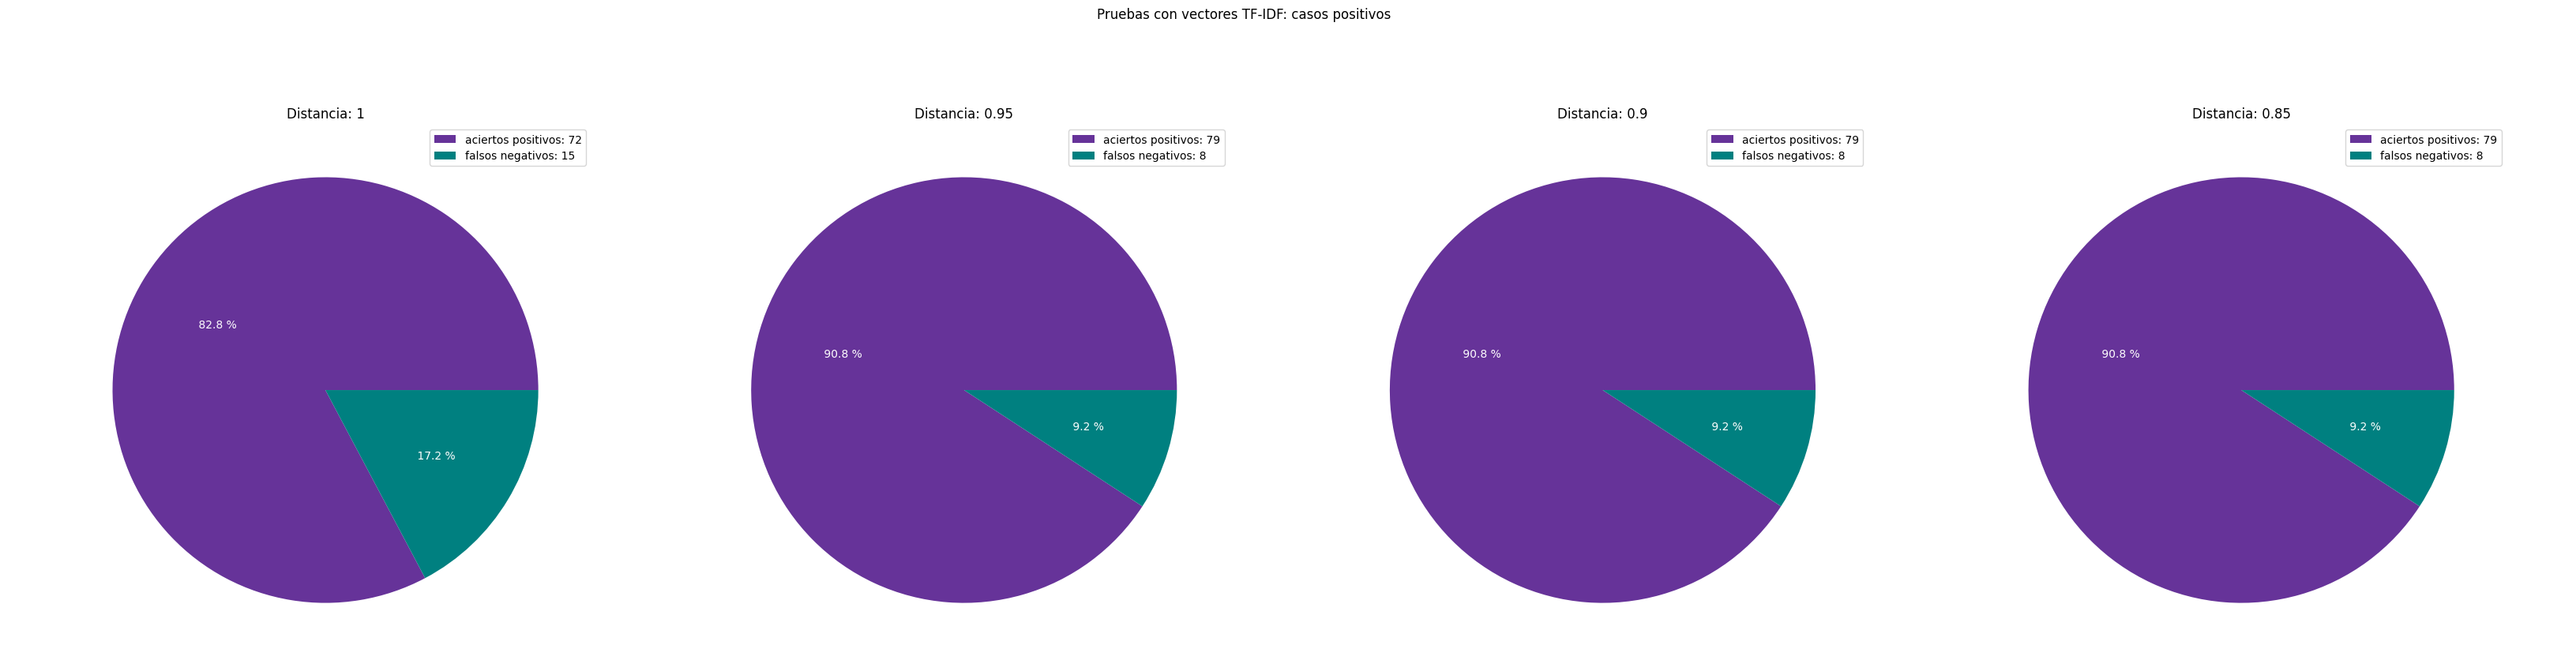

In [13]:
fig, axes = plt.subplots(1, 4, figsize = (40, 10))
fig.suptitle("Pruebas con vectores TF-IDF: casos positivos")
for index, row in df_results_val.iterrows():
  y = np.array([row['aciertos_positivos'], row['falsos_negativos']])
  mylabels = ['aciertos positivos: ' + str(row['aciertos_positivos']), 'falsos negativos: ' + str(row['falsos_negativos'])]

  axes[index].pie(y, labels = mylabels, autopct ='% 1.1f %%', colors = ['rebeccapurple', 'teal'], textprops={'color':"w"})
  axes[index].set_title("Distancia: " + str(row['distancia']))
  axes[index].legend()

plt.show()

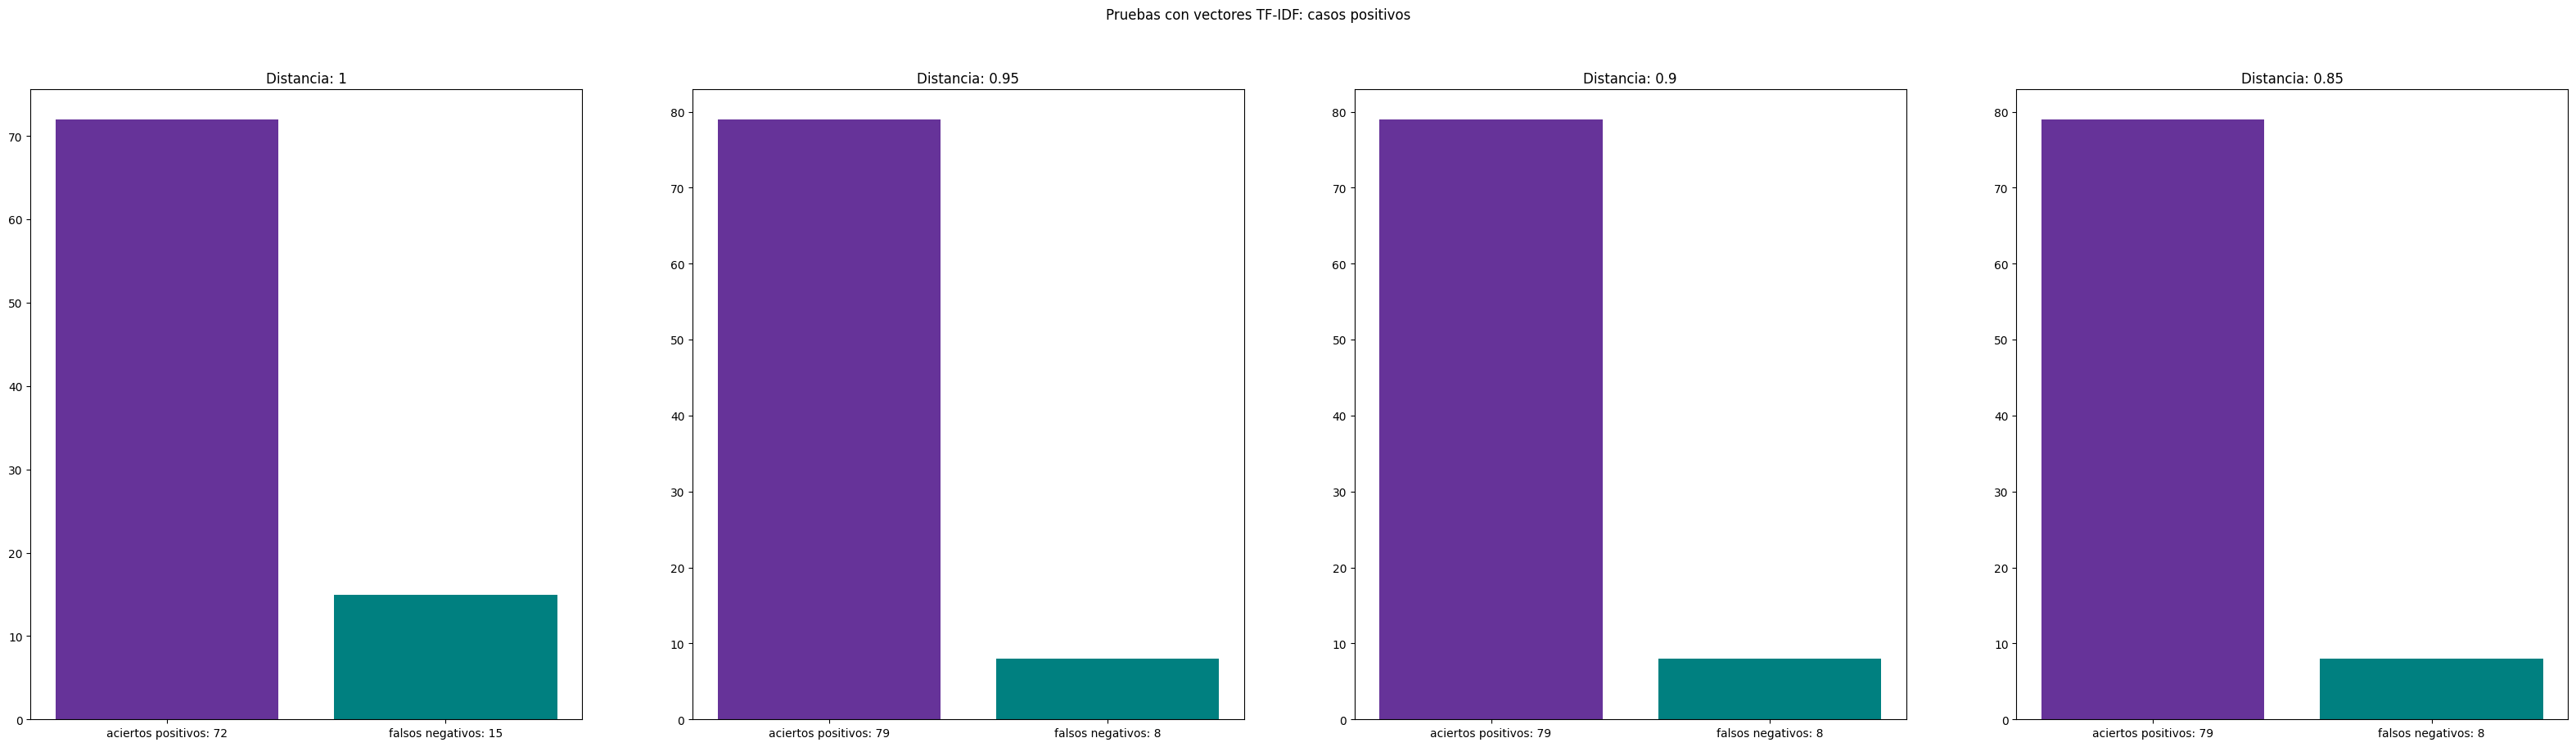

In [11]:
fig, axes = plt.subplots(1, 4, figsize = (40, 10))
fig.suptitle("Pruebas con vectores TF-IDF: casos positivos")
for index, row in df_results_val.iterrows():
  y = np.array([row['aciertos_positivos'], row['falsos_negativos']])
  mylabels = ['aciertos positivos: ' + str(row['aciertos_positivos']), 'falsos negativos: ' + str(row['falsos_negativos'])]

  axes[index].bar(mylabels, y, color = ['rebeccapurple', 'teal'])
  axes[index].set_title("Distancia: " + str(row['distancia']))

plt.show()

### Casos etiquetados como **negativos**
Se muestran los aciertos negativos y los falsos positivos, que suman los casos que están etiquetados como 0, es decir, los que no tienen ningún autor con el que enlazarse.

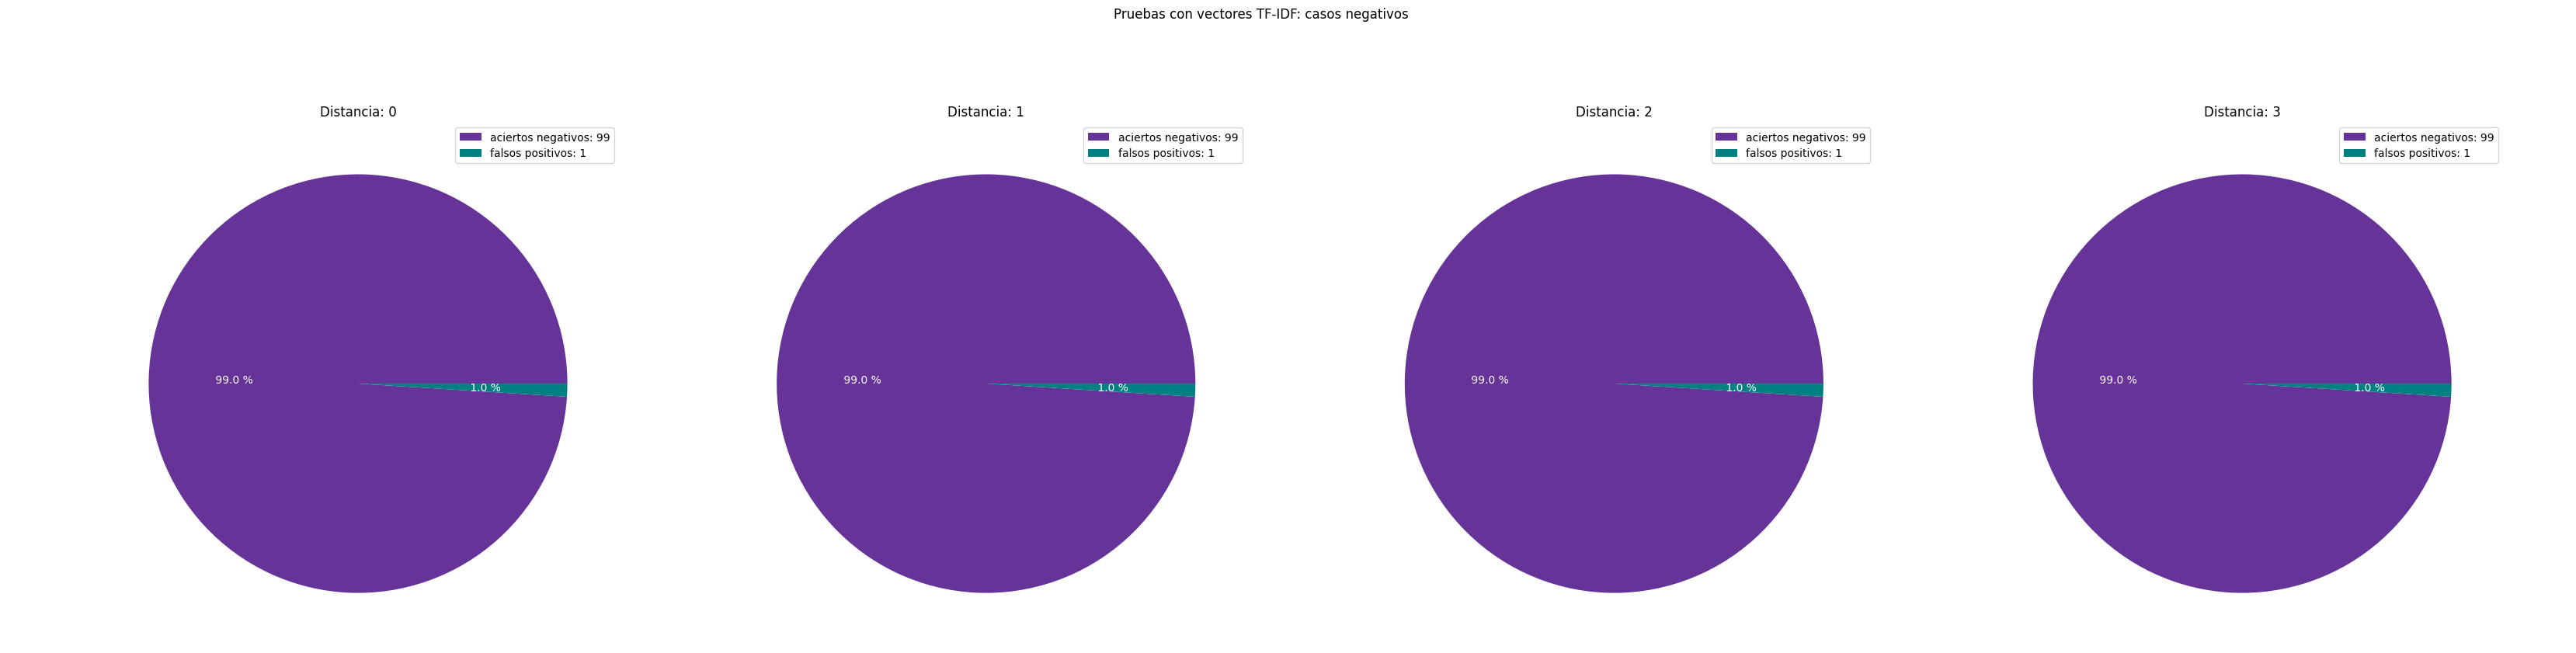

In [14]:
fig, axes = plt.subplots(1, 4, figsize = (40, 10))
fig.suptitle("Pruebas con vectores TF-IDF: casos negativos")
for index, row in df_results_val.iterrows():
  y = np.array([row['aciertos_negativos'], row['falsos_positivos']])
  mylabels = ['aciertos negativos: ' + str(row['aciertos_negativos']), 'falsos positivos: ' + str(row['falsos_positivos'])]

  axes[index].pie(y, labels = mylabels, autopct ='% 1.1f %%', colors = ['rebeccapurple', 'teal'], textprops={'color':"w"})
  axes[index].set_title("Distancia: " + str(index))
  axes[index].legend()

plt.show()

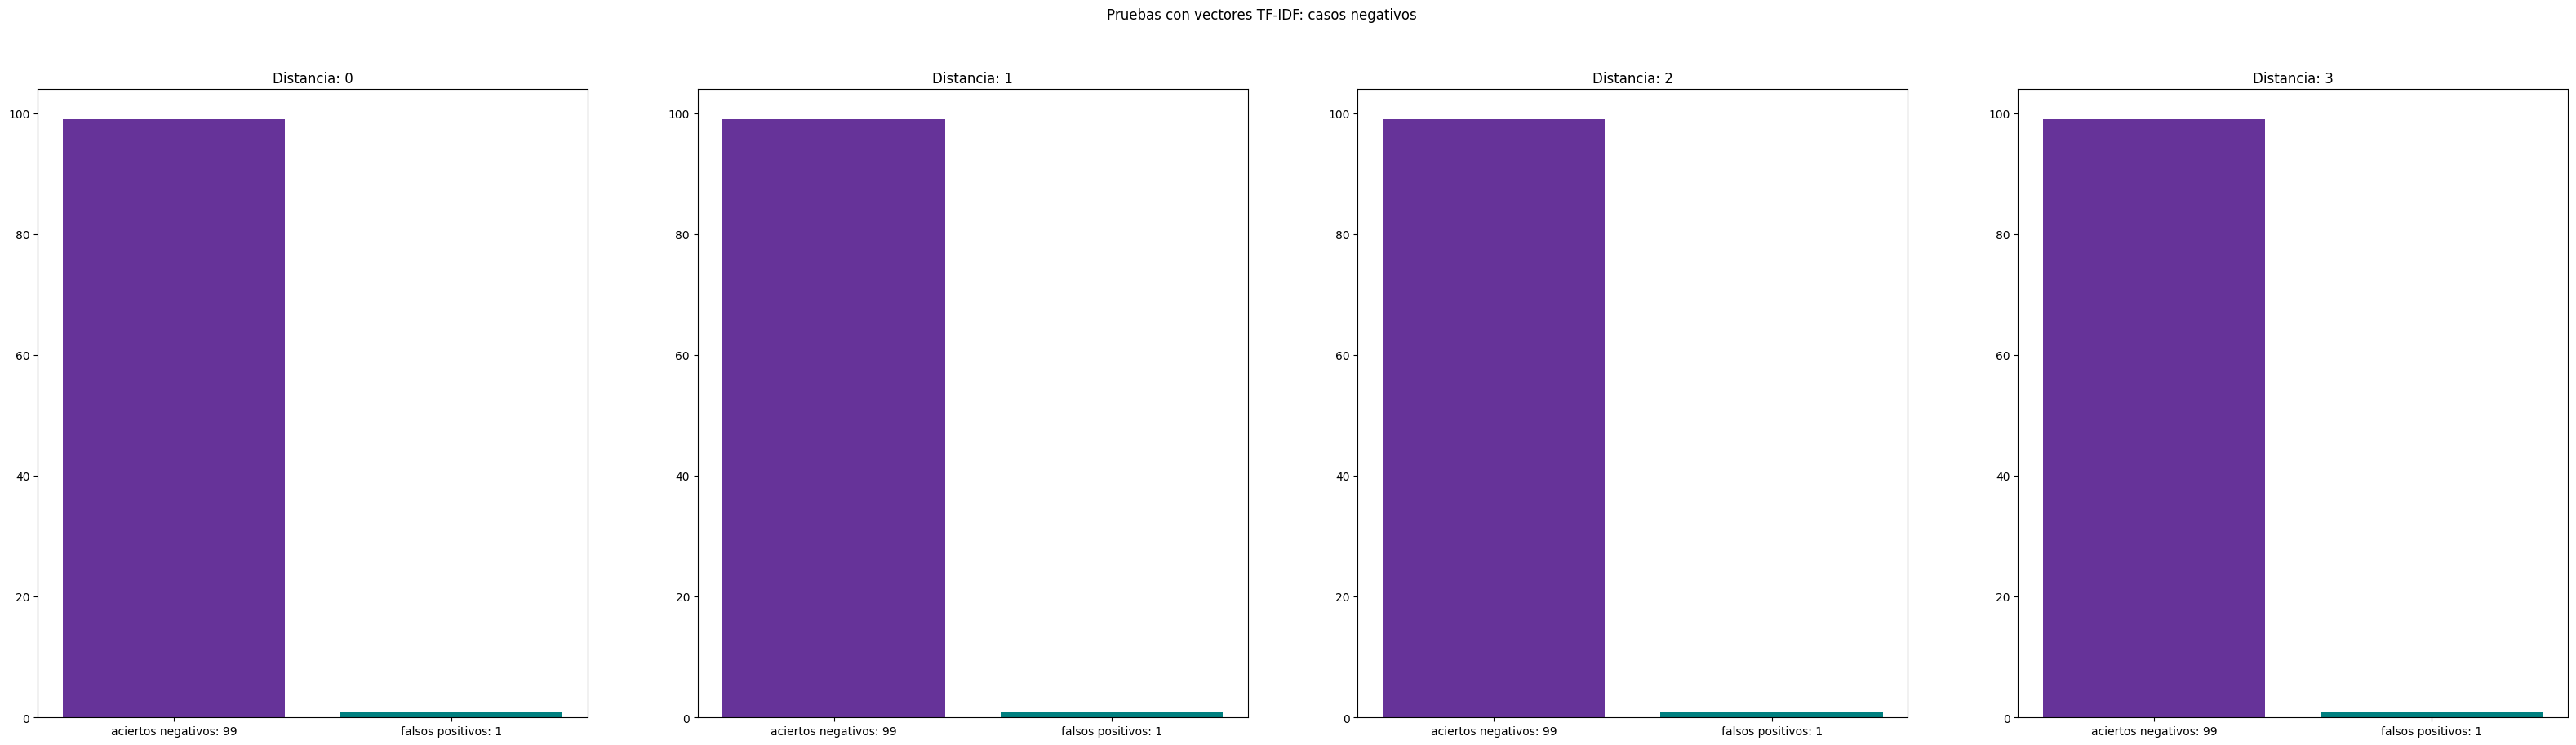

In [12]:
fig, axes = plt.subplots(1, 4, figsize = (40, 10))
fig.suptitle("Pruebas con vectores TF-IDF: casos negativos")
for index, row in df_results_val.iterrows():
  y = np.array([row['aciertos_negativos'], row['falsos_positivos']])
  mylabels = ['aciertos negativos: ' + str(row['aciertos_negativos']), 'falsos positivos: ' + str(row['falsos_positivos'])]

  axes[index].bar(mylabels, y, color = ['rebeccapurple', 'teal'])
  axes[index].set_title("Distancia: " + str(index))

plt.show()

# Métricas


In [ ]:
df_val_set = pd.read_csv('/content/drive/MyDrive/TFM/notebooks/entrega/tfidf_result_val.csv', index_col = 0)

In [ ]:
threshold = [0.2, 0.15, 0.1, 0.05, 0]
test = []
for i in threshold:
  print('Threshold: ' + str(i))
  evaluate_model(df_val_set['label'], (df_val_set['cosine_similarity'] >= i))

Threshold: 0.2
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.73      0.96      0.83       100
           1       0.80      0.31      0.44        52

    accuracy                           0.74       152
   macro avg       0.76      0.63      0.64       152
weighted avg       0.75      0.74      0.70       152

Accuracy -> 73.68%



Threshold: 0.15
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       100
           1       0.84      0.50      0.63        52

    accuracy                           0.80       152
   macro avg       0.81      0.72      0.74       152
weighted avg       0.80      0.80      0.78       152

Accuracy -> 79.61%



Threshold: 0.1
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       100
           1       0.73      0.69      0.71        52

    accuracy                           0.81       152
   macro avg       0.79      0.78      0.79       152
weighted avg       0.81      0.81      0.81       152

Accuracy -> 80.92%



Threshold: 0.05
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.93      0.81      0.87       100
           1       0.71      0.88      0.79        52

    accuracy                           0.84       152
   macro avg       0.82      0.85      0.83       152
weighted avg       0.85      0.84      0.84       152

Accuracy -> 83.55%



Threshold: 0
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.34      1.00      0.51        52

    accuracy                           0.34       152
   macro avg       0.17      0.50      0.25       152
weighted avg       0.12      0.34      0.17       152

Accuracy -> 34.21%



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

